In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sqlalchemy import create_engine

# Koneksi Database

In [2]:
dbname="order_management"
user="postgres"
password="admin"
host="localhost"
port="5432"

# Buat engine koneksi
engine = create_engine(f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{dbname}')

# Query dari view
query = "SELECT * FROM tampilan_penjualan_harian"

# Masukkan ke dataframe
df = pd.read_sql(query, engine)

df

,tanggal_penjualan,total_pendapatan_harian,jumlah_faktur_harian
0,2024-11-30,660000.0,1
1,2024-12-02,180000.0,1
2,2024-12-04,540000.0,3
3,2024-12-15,1805000.0,5
4,2024-12-17,755000.0,3
...,...,...,...
72,2025-05-13,315000.0,4
73,2025-05-18,440000.0,3
74,2025-05-19,730000.0,2
75,2025-05-26,850000.0,2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   tanggal_penjualan        77 non-null     object 
 1   total_pendapatan_harian  77 non-null     float64
 2   jumlah_faktur_harian     77 non-null     int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.9+ KB


# Pre-Processing

In [4]:
# Salin dan preprocessing awal
df = df.copy()
df['tanggal_penjualan'] = pd.to_datetime(df['tanggal_penjualan'])  # ubah ke datetime
df = df.sort_values('tanggal_penjualan')  # urutkan kronologis
df = df.set_index('tanggal_penjualan')    # jadikan index
df

,total_pendapatan_harian,jumlah_faktur_harian
tanggal_penjualan,,
2024-11-30,660000.0,1
2024-12-02,180000.0,1
2024-12-04,540000.0,3
2024-12-15,1805000.0,5
2024-12-17,755000.0,3
...,...,...
2025-05-13,315000.0,4
2025-05-18,440000.0,3
2025-05-19,730000.0,2


In [5]:
# Isi tanggal yang hilang secara harian
all_dates = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
df = df.reindex(all_dates)
df['total_pendapatan_harian'] = df['total_pendapatan_harian'].fillna(0)
df['jumlah_faktur_harian'] = df['jumlah_faktur_harian'].fillna(0)
df

,total_pendapatan_harian,jumlah_faktur_harian
2024-11-30,660000.0,1.0
2024-12-01,0.0,0.0
2024-12-02,180000.0,1.0
2024-12-03,0.0,0.0
2024-12-04,540000.0,3.0
...,...,...
2025-05-25,0.0,0.0
2025-05-26,850000.0,2.0
2025-05-27,0.0,0.0
2025-05-28,0.0,0.0


In [6]:
# Siapkan data untuk Prophet
df_prophet = df[['total_pendapatan_harian']].reset_index().rename(columns={
    'index': 'ds',
    'total_pendapatan_harian': 'y'
})

In [7]:
# Inisialisasi dan latih model Prophet
model = Prophet(daily_seasonality=True)
model.fit(df_prophet)

# Prediksi 5 hari ke depan
future = model.make_future_dataframe(periods=5)
forecast = model.predict(future)
future_forecast = forecast[['ds', 'yhat']].tail(5)

12:48:02 - cmdstanpy - INFO - Chain [1] start processing
12:48:02 - cmdstanpy - INFO - Chain [1] done processing


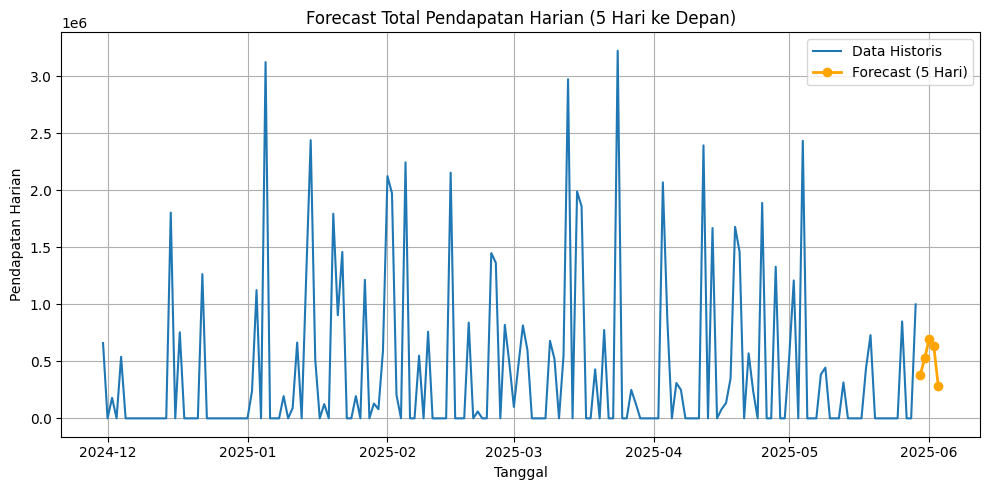

In [8]:
# Visualisasi bergaya custom
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['total_pendapatan_harian'], label='Data Historis', linewidth=1.5)
plt.plot(future_forecast['ds'], future_forecast['yhat'], label='Forecast (5 Hari)', marker='o', color='orange', linewidth=2)
plt.legend()
plt.xlabel('Tanggal')
plt.ylabel('Pendapatan Harian')
plt.title('Forecast Total Pendapatan Harian (5 Hari ke Depan)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
# Data historis
df_historis = df_prophet.rename(columns={'ds': 'tanggal', 'y': 'total_pendapatan_harian'})
df_historis['status'] = 'aktual'

# Data prediksi
df_prediksi = future_forecast.rename(columns={
    'ds': 'tanggal',
    'yhat': 'total_pendapatan_harian'
})
df_prediksi['status'] = 'prediksi'

# Gabungkan semua
df_final = pd.concat([df_historis, df_prediksi], ignore_index=True)
df_final = df_final.sort_values('tanggal').reset_index(drop=True)

In [10]:
df_final.tail(10)

,tanggal,total_pendapatan_harian,status
176,2025-05-25,0.000000,aktual
177,2025-05-26,850000.000000,aktual
178,2025-05-27,0.000000,aktual
179,2025-05-28,0.000000,aktual
180,2025-05-29,1000000.000000,aktual
181,2025-05-30,378485.542714,prediksi
182,2025-05-31,527328.137485,prediksi
183,2025-06-01,694943.776495,prediksi
184,2025-06-02,637981.801216,prediksi
185,2025-06-03,286517.662573,prediksi


In [11]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   tanggal                  186 non-null    datetime64[ns]
 1   total_pendapatan_harian  186 non-null    float64       
 2   status                   186 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 4.5+ KB


In [12]:
df_final.to_sql('hasil_forecasting_total_pendapatan_harian', engine, index=False, if_exists='replace')

186